## Imports and Setup

In [ ]:
import os
import pandas as pd
import geopandas as gpd
import logging
import joblib
import torch

import sys
sys.path.insert(0, "../src")
import sat_download

sys.path.insert(0, "../utils/")
import post_utils
import config_utils
import data_utils

import matplotlib.pyplot as plt
from PIL import Image

%load_ext autoreload
%autoreload 2

## Load Config Files

In [420]:
iso_code = "SEN"
sum_threshold = 5

cwd = os.path.dirname(os.getcwd())
data_config_file = os.path.join(cwd, "configs/AF_config.yaml")
data_config = config_utils.load_config(data_config_file)

model_config_file = os.path.join(cwd, "configs/cnn_configs/convnext_large_v01.yaml")
model_config = config_utils.load_config(model_config_file)

## Load Data

In [421]:
master_file = f"{iso_code}_master.geojson"
master = gpd.read_file(master_file)
print(master.shape)
master.head(2)

(10065, 12)


,MUID,source,iso,country,region,subregion,name,giga_id_school,clean,distance,PUID,geometry
0,UNICEF-SEN-SCHOOL-00000000,UNICEF,SEN,Senegal,Africa,Sub-Saharan Africa,EE ALIEU SAMB,7614c6c6-9aca-36ff-978b-22bfca59916a,0,101.064944,10390,POINT (-17.51261 14.74680)
1,UNICEF-SEN-SCHOOL-00000001,UNICEF,SEN,Senegal,Africa,Sub-Saharan Africa,EE EL HADJI BAYTIR SAMB,350fb172-bfef-331d-bd55-5c51139b9f48,0,394.084768,10390,POINT (-17.51196 14.74951)


In [422]:
pred_file = f"{iso_code}_results.geojson"
preds = gpd.read_file(pred_file)
print(preds.shape)
preds.head(2)

(14635, 11)


,PUID,prob,sum,group,MUID,master_name,distance_to_nearest_master,SUID,source_name,distance_to_nearest_osm_overture,geometry
0,0,0.986333,6.0,9737,UNICEF-SEN-SCHOOL-00008573,CEM MBANE,186.316861,OSM-SEN-SCHOOL-00000624,Daara Tiékéne,9866.032713,POINT (-1758008.065 1836347.000)
1,1,0.986281,113.0,801,UNICEF-SEN-SCHOOL-00006581,CEM OGO DIOP,27.629348,OSM-SEN-SCHOOL-00000707,complexe seydi family,344.020000,POINT (-1939072.473 1662641.600)


## Post-prediction Analysis

INFO:root:clean
0    8518
2    1310
1     237
Name: count, dtype: int64


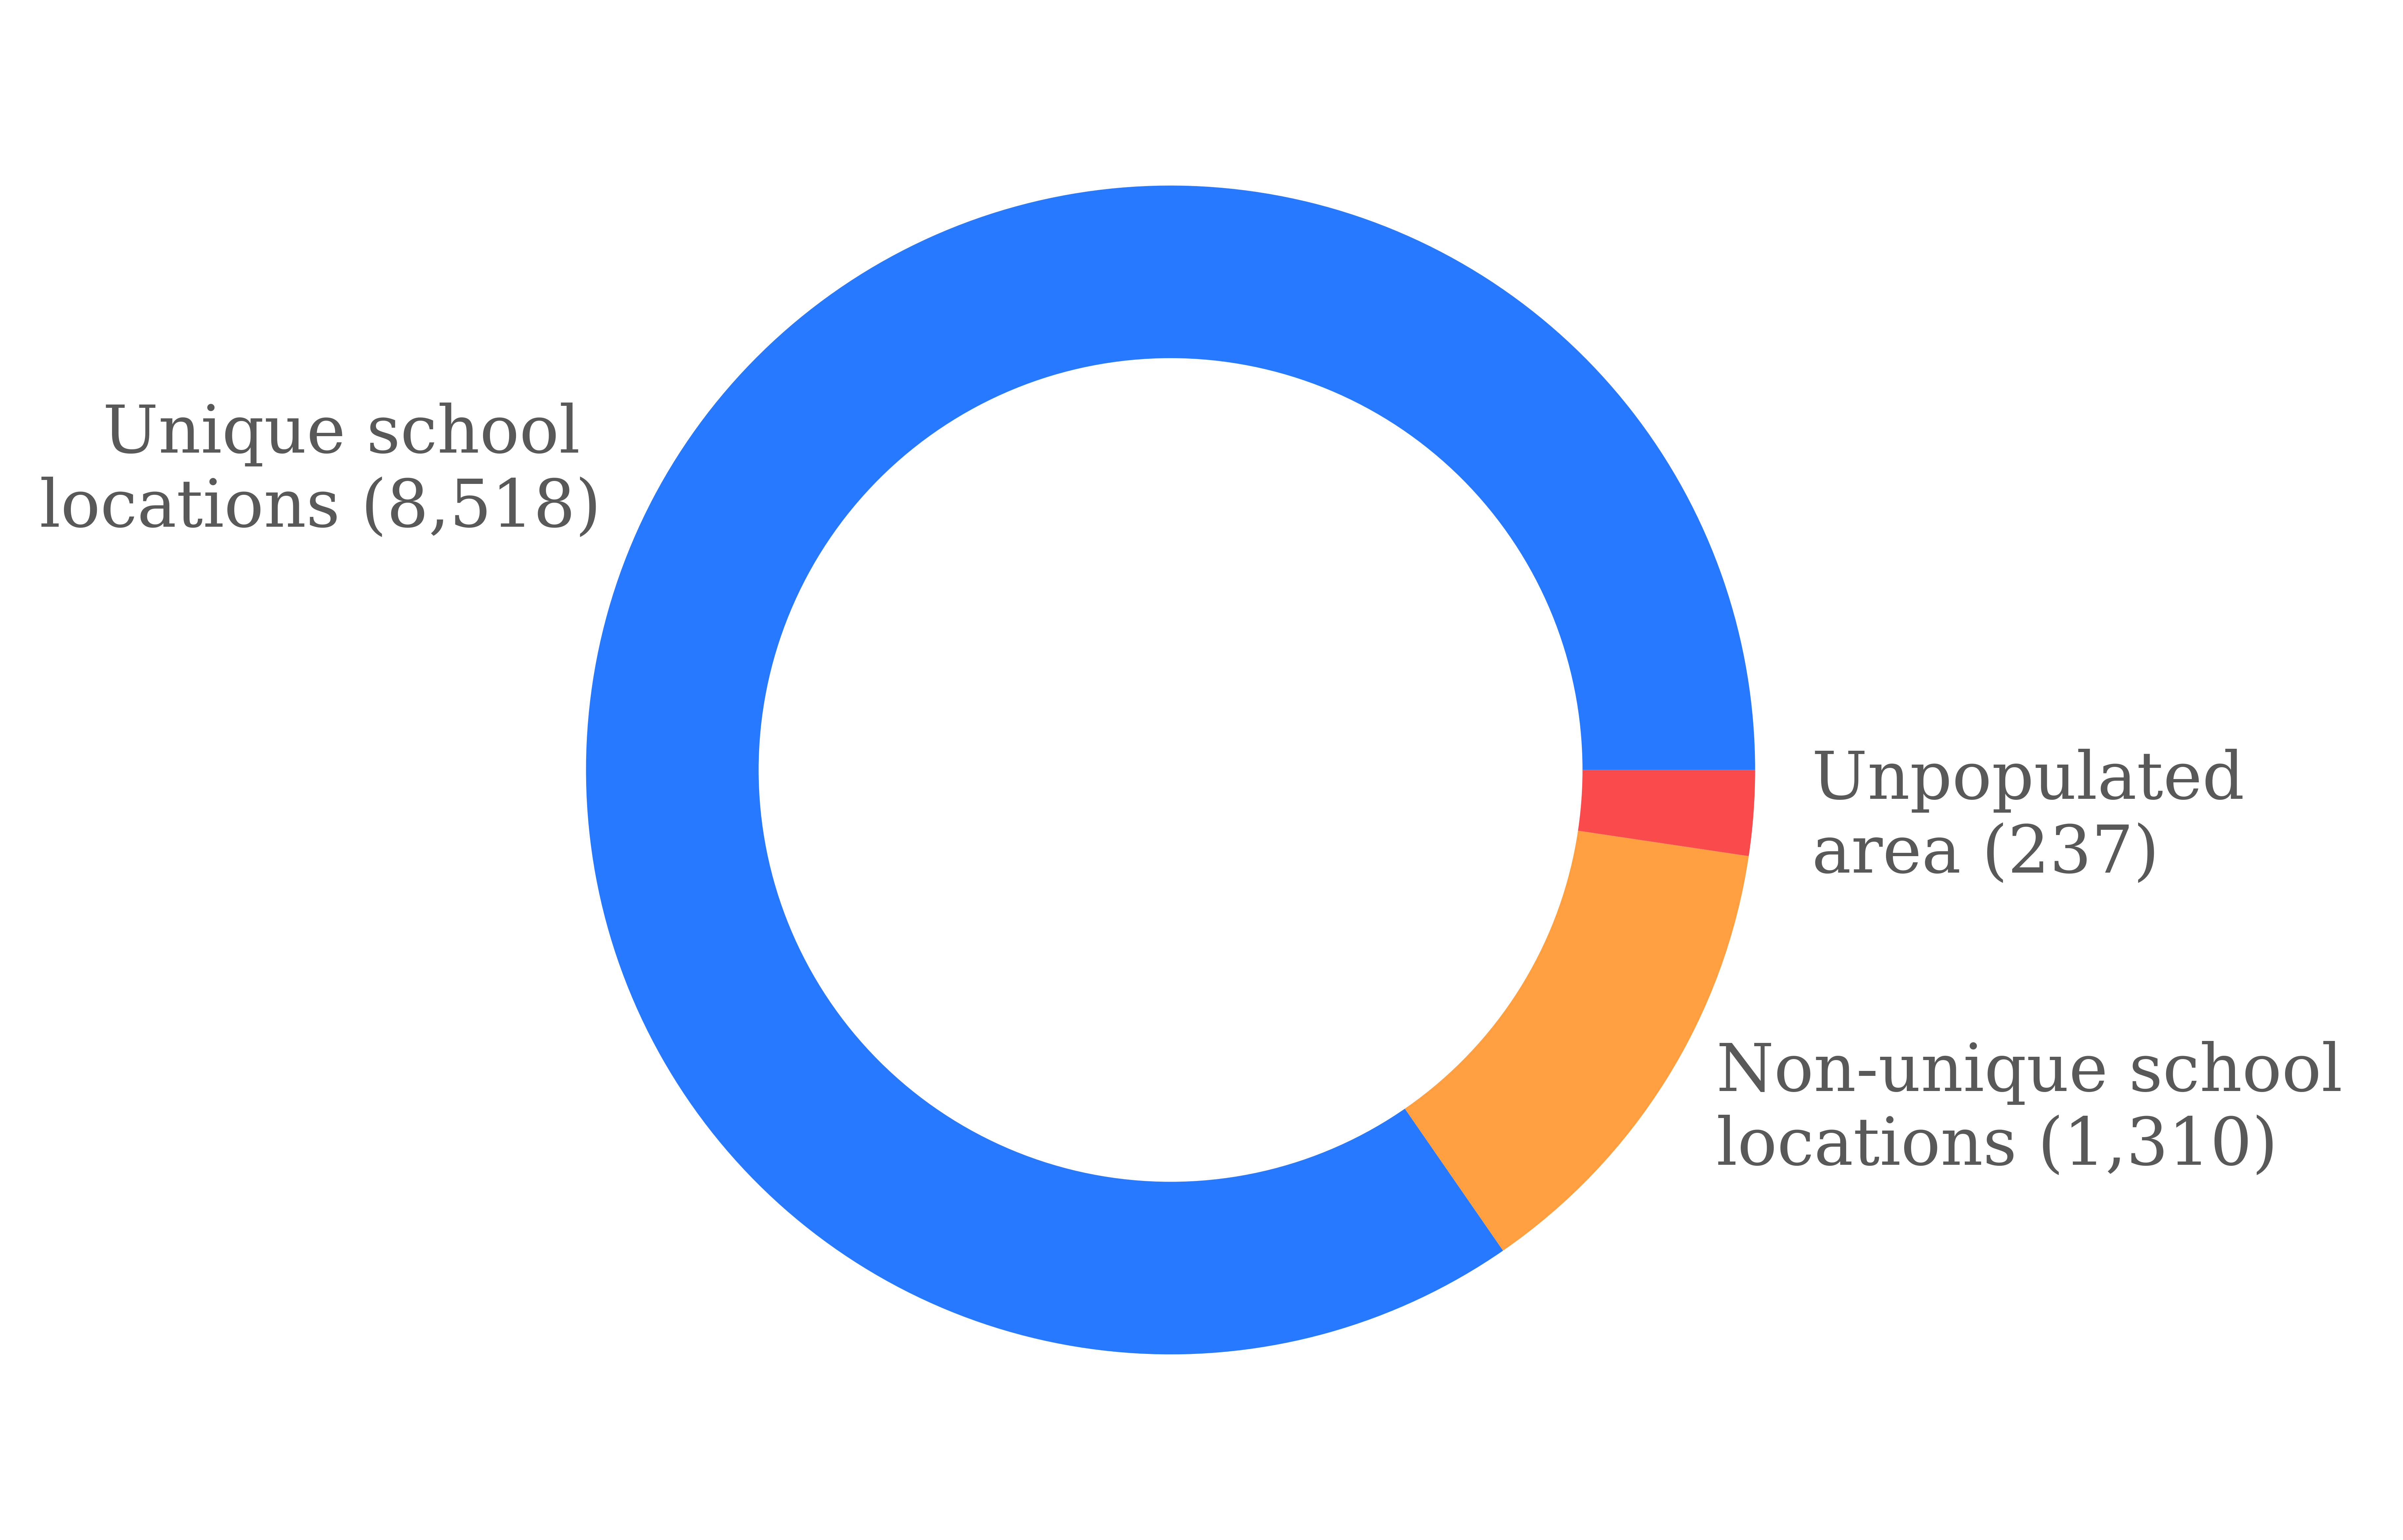

In [423]:
post_utils.donut_chart(master, source="master")

INFO:root:(6880, 12), (6880, 11)


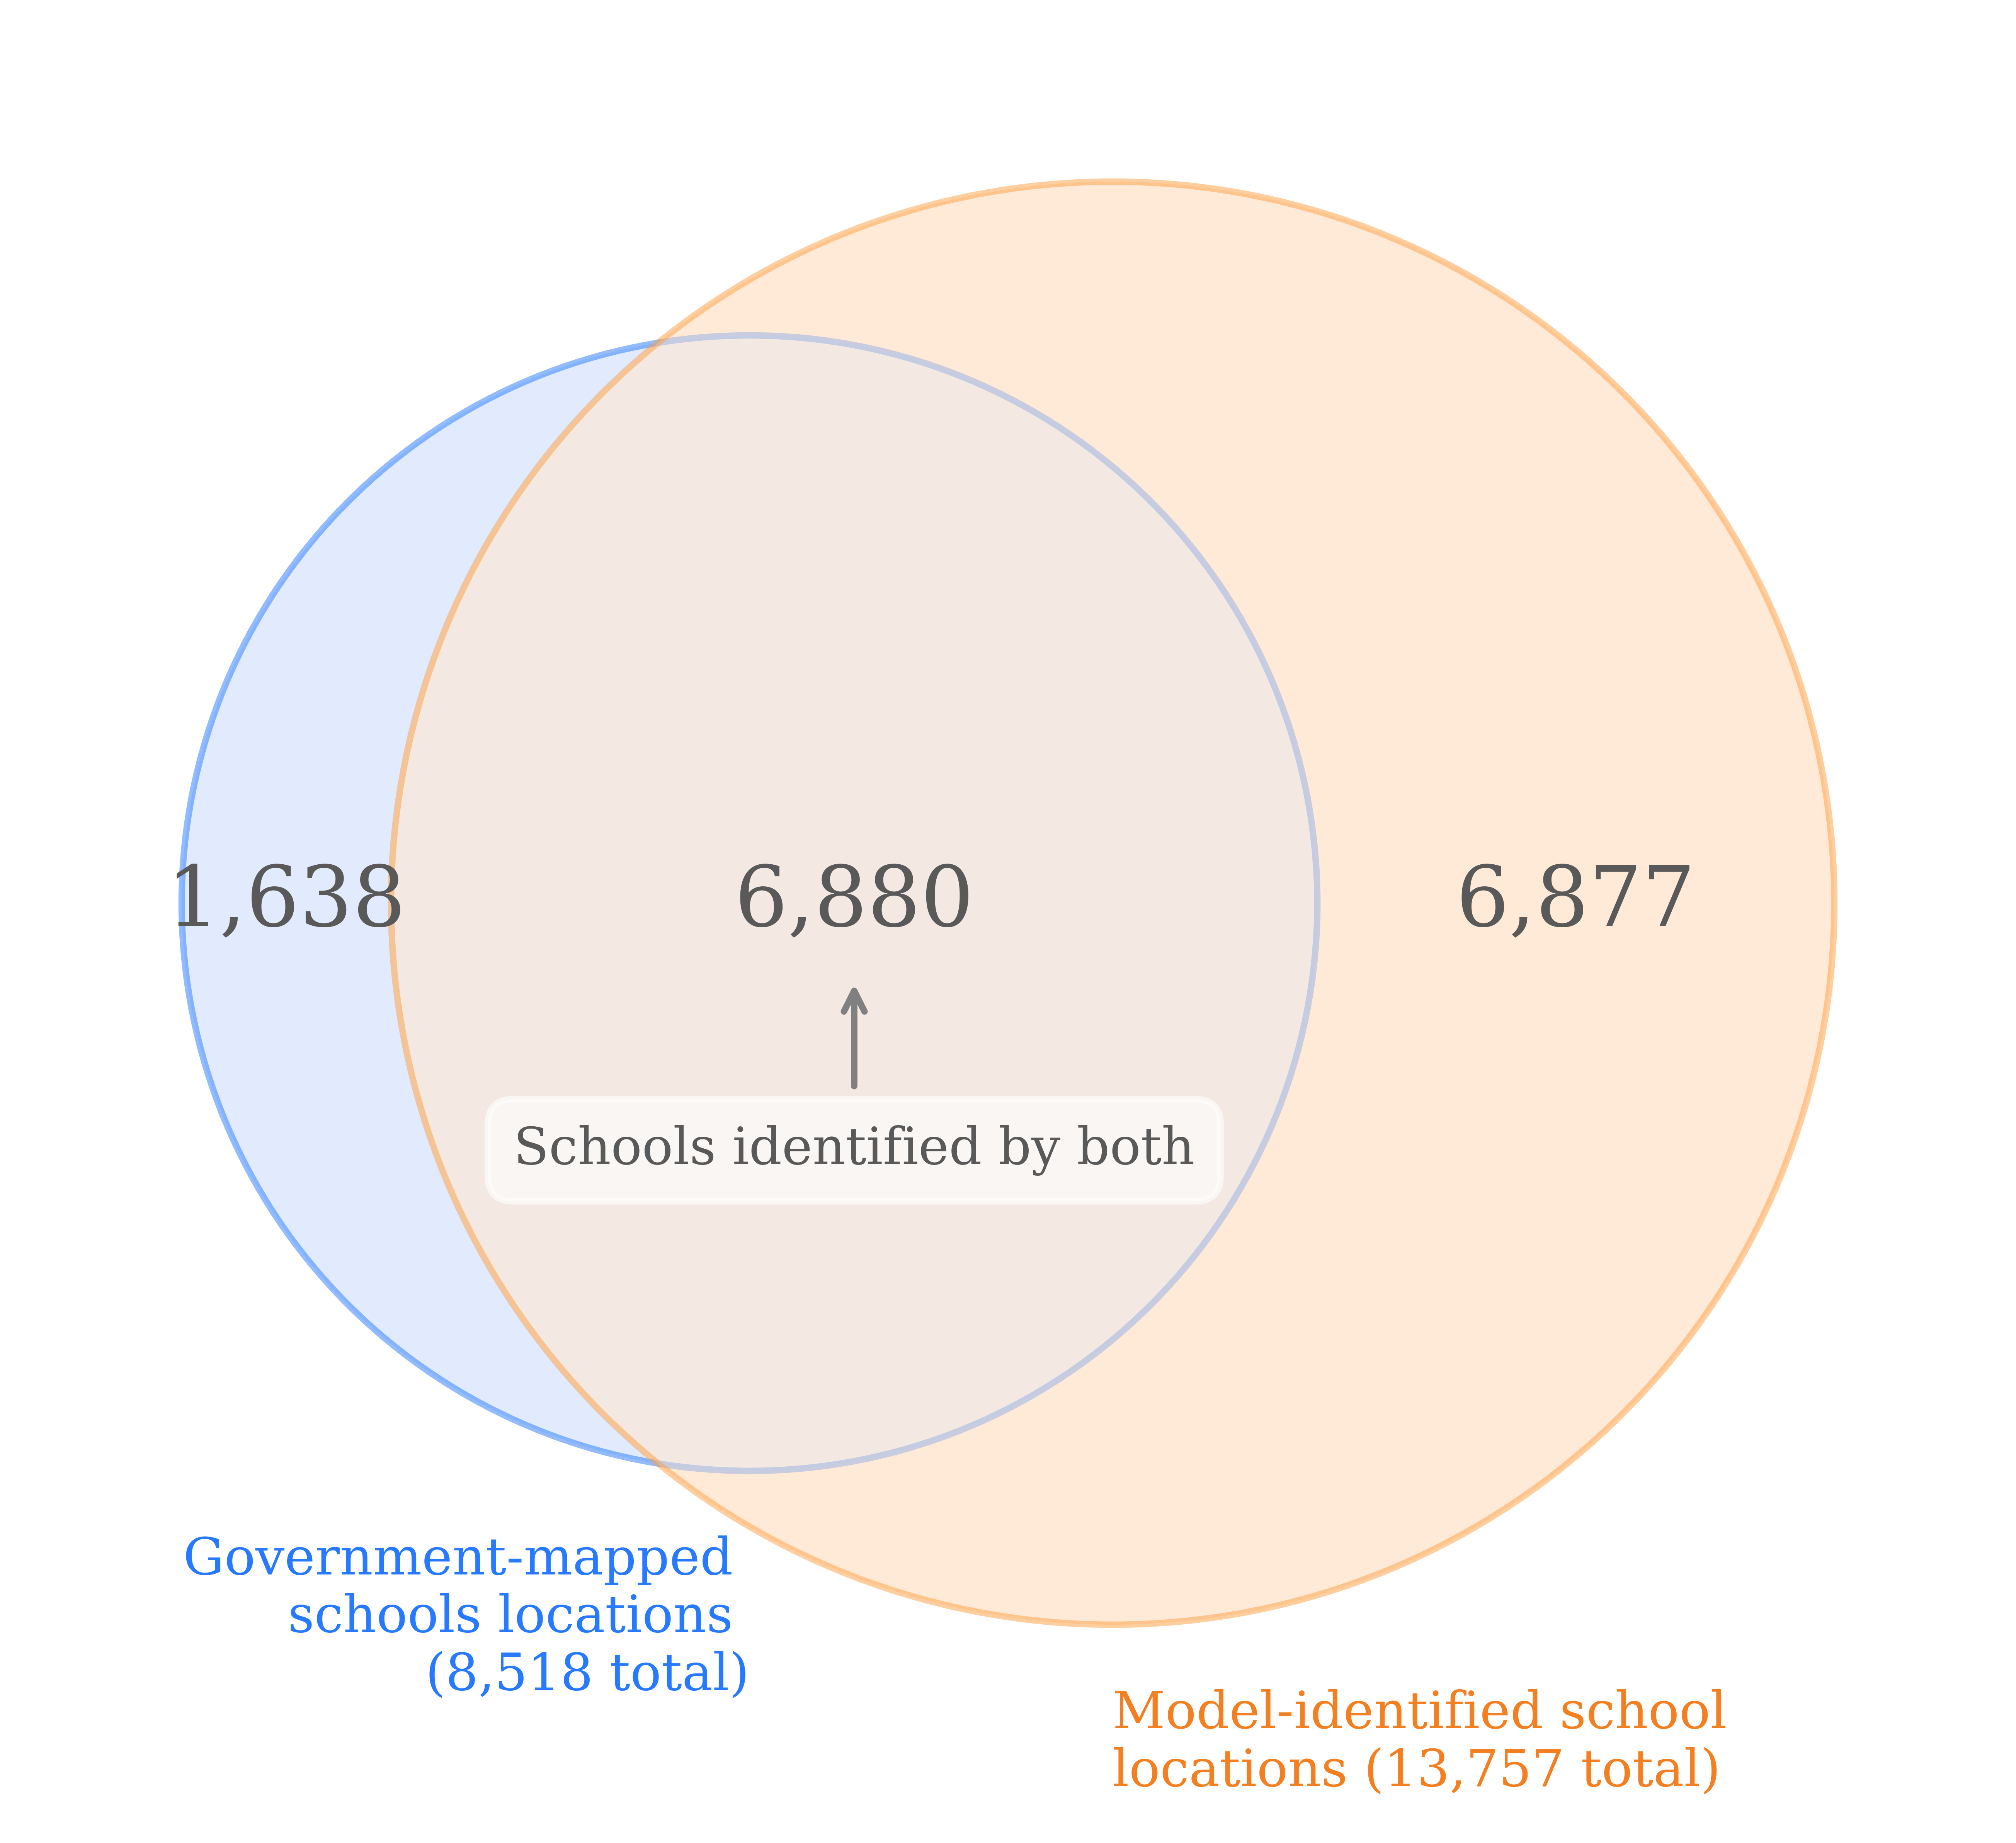

In [424]:
post_utils.venn_diagram(master, preds, threshold_dist=250)

INFO:root:(6880, 12), (6880, 11)


<Figure size 7680x5760 with 0 Axes>

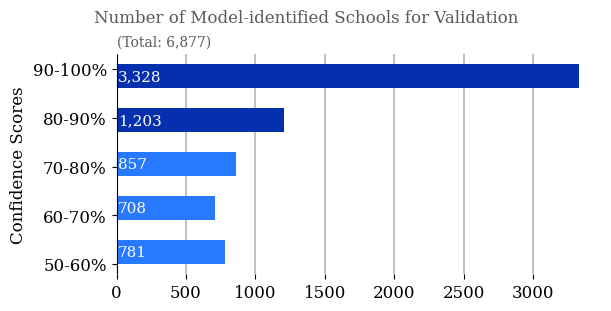

In [425]:
post_utils.show_barplot(master, preds, pad=10)

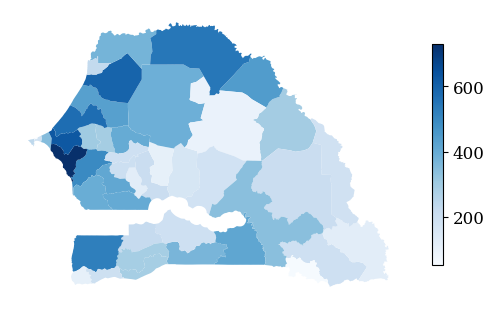

In [429]:
master_plot, preds_plot, diff = post_utils.join_with_geoboundaries(master, preds,  data_config, iso_code)
vmax = np.max([np.max(master_plot.n_points.values), np.max(preds_plot.n_points.values)])
post_utils.plot_choropleth(preds_plot, column="n_points", cmap='Blues', shrink=0.6, vmax=vmax)